In [1]:
from model_utils import configuration as cnf
from plotting import model_plots
from plotting import data_plots
from model_utils import initialisation as init
import sectors
import pyomo.environ as pyo

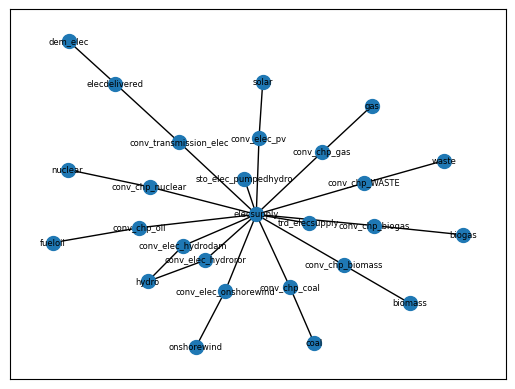

In [2]:
# Show network complexity
data_plots.plot_io_network(cnf.DATA)

In [3]:
# Model setup
model = init.init_model()

sectors.trade.configure_sector(model)
sectors.extraction.configure_sector(model)
sectors.storage.configure_sector(model)

sectors.electricity.configure_sector(model)
sectors.transmission.configure_sector(model)
# # sectors.passenger.configure_sector(model)

sectors.demands.configure_sector(model)

In [4]:
tot_cost_expr = model.dem_e_CostTotal + model.elec_e_CostTotal + model.ext_e_CostTotal + model.sto_e_CostTotal + model.trd_e_CostTotal + model.etrans_e_CostTotal

In [5]:
# tot_cost_expr = model.e_costinv + model.e_costfixedom + model.e_costvar - model.e_revenuevar
model.cost = pyo.Objective(expr=tot_cost_expr, sense=pyo.minimize)
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

opt = pyo.SolverFactory("gurobi", solver_io="python")
opt.options["MIPGap"] = 1e-2
opt.options["Timelimit"] = 1800
try:
    opt_result = opt.solve(model, tee=False)
    print(opt_result)
except ValueError:
    model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})


Problem: 
- Name: unknown_copy
  Lower bound: 10739437939.570637
  Upper bound: 10739437939.570637
  Number of objectives: 1
  Number of constraints: 70271
  Number of variables: 50547
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 50547
  Number of nonzeros: 174526
  Sense: 1
  Number of solutions: 1
Solver: 
- Name: Gurobi 9.52
  Status: ok
  Wallclock time: 1.4882428646087646
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



# Plotting

In [ ]:
model.e_TotalAnnualActivity["trd_elecsupply", 1990]()

<AxesSubplot:title={'center':"Modelled:Input:['elecsupply']"}, ylabel='TWh'>

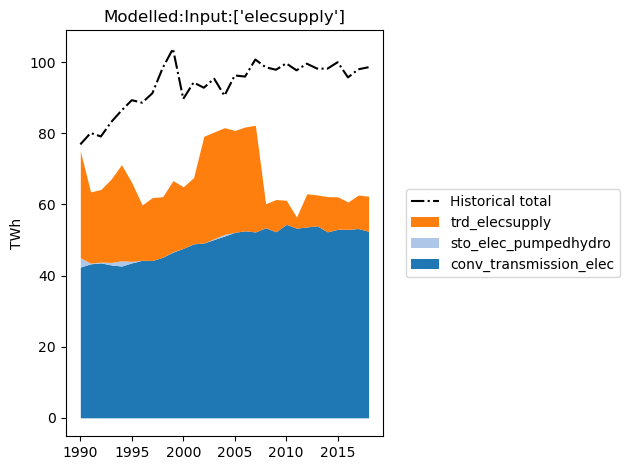

In [6]:
model_plots.plot_flow_fin(model, cnf.DATA, ["elecsupply"], unit="TWh", hist="elecsupply")

In [ ]:
model_plots.plot_flow_fout(model, cnf.DATA, ["elecsupply"], unit="TWh", hist="elecsupply")

In [ ]:
model_plots.plot_group_ctot(model, ["_elec_", "_chp_"], unit="GW")

In [ ]:
model_plots.plot_act(model, "sto_elec_pumpedhydro", unit="TWh")

# Debug
Check your model run :)

In [ ]:
from pyomo.util import infeasible
infeasible.log_infeasible_constraints(model, log_expression=True, log_variables=True)
infeasible.log_infeasible_bounds(model)
# infeasible.log_close_to_bounds(model)

In [ ]:
import gurobi

model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})
m = gurobi.read("debug.lp")
m.optimize()
m.computeIIS()
m.write("debug_{0}.ilp".format("CHE"))